# E-tivity 3

Student name: Sorin Slavescu
Student id: 21185131

    * Plot the sum of squared distances from the data points (in loans_train_prepared.csv) to the centers of the k-means clusters for various values of k.
    * Use the Elbow method to pick the best value of k.
    * Attempt also another method for determining the best value of k.
    * Use the best value(s) of k to cluster the loans_train_prepared dataset with k-means. Aim at producing meaningful clustering.
    * Use at least two different methods for visualising the clustering. Write a short conclusion about the characteristics of the clusters (max 250 words in a markdown cell).

### A. Import Python Modules and Dataset

In [274]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

#### Load the dataset

In [275]:
df = pd.read_csv("./loans_train_prepared-1.csv")
data = np.array(df.values, dtype=float)
print('(number of examples, number of attributes): ', data.shape)

(number of examples, number of attributes):  (614, 16)


### B. Rescale the Data
Here we rescale the values in each column to the interval $[0,1]$ with MinMaxScaler. Please note that if your dataset is already prepared for ML there is no need to rescale it again. See https://scikit-learn.org/stable/modules/preprocessing.html for alternative rescaling techniques. In your work on this exercise experiment with other rescaling techniques to see if they lead to a more insightful clustering.

In [276]:
min_max_scaler = preprocessing.MinMaxScaler()
data = min_max_scaler.fit_transform(data)

### C. Scatterplot Function (to be used below for visualising a clustering)

Skip this section when you read the notebook for the first time.

The function `clustering_scatterplot()` creates the 2D scatter plot of the clustered dataset.

In [277]:
colors = np.array(['orange', 'blue', 'lime', 'cyan', 'khaki', 'pink', 'green', 'purple'])

# points - a 2D array of (x,y) coordinates of data points
# labels - an array of numeric labels in the interval [0..k-1], one for each point
# centers - a 2D array of (x, y) coordinates of cluster centers
# title - title of the plot


def clustering_scatterplot(points, labels, centers, title):
    
    
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        h = plt.scatter(points[labels==i,0],
                        points[labels==i,1], 
                        c=colors[i%colors.size],
                        label = 'cluster '+str(i))

    # plot the centers of the clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='r', marker='*', s=500)

    _ = plt.title(title)
    _ = plt.legend()
    _ = plt.xlabel('x')
    _ = plt.ylabel('y')

In [278]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Dependents               614 non-null    float64
 1   ApplicantIncome          614 non-null    float64
 2   LoanAmount               614 non-null    float64
 3   Loan_Amount_Term         614 non-null    float64
 4   Credit_History           614 non-null    int64  
 5   Gender_Male              614 non-null    int64  
 6   Gender_nan               614 non-null    int64  
 7   Married_Yes              614 non-null    int64  
 8   Married_nan              614 non-null    int64  
 9   Self_Employed_Yes        614 non-null    int64  
 10  Self_Employed_nan        614 non-null    int64  
 11  Education_Not Graduate   614 non-null    int64  
 12  Property_Area_Semiurban  614 non-null    int64  
 13  Property_Area_Urban      614 non-null    int64  
 14  Loan_Status_Y            6

# Finding the optimal number of clusters

We have to identify a clustering approach that makes business sense. A large number of clusters will be difficult to explain hence I'm not going to try finding more than 10 clusters

I have also noticed that putting all features through the clustering algorithm doesn't produce a clear way of clustering the data, the SSE and the Silhouette Coefficients seem to be behaving differently. Therefore, I have selected only a subset of features to put through the clustering algorithm and this produces some more human explainable results. The group of features to use is all up to a subject matter expert from the business that is looking to interpret this data. My intuition tells me that for the purpose of identifying whether a person is suitable to get a loan I will exclude some features such as gender, marrital status, education and address and will only consider if the person is self employed or not


### K-Means Clustering using the Sum of Squared Errors (Elbow) method

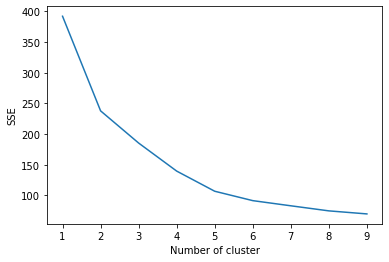

In [279]:
X = pd.DataFrame(data)
X_to_cluster = X[[0, 1, 2, 3, 4, 9, 14, 15]]
#print(X)

sse = {}
labels_sse = {}
for k in range(1, 10):
    kmeans_sse = cluster.KMeans(n_clusters=k, max_iter=1000).fit(X_to_cluster)
    #kmeans = cluster.KMeans(n_clusters=k, max_iter=1000).fit(X)
    #X["clusters"] = kmeans.labels_
    labels_sse[k] = kmeans_sse.labels_
    #print(data["clusters"])
    sse[k] = kmeans_sse.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

# KMeans Clustering using Silhouette Coefficient Method

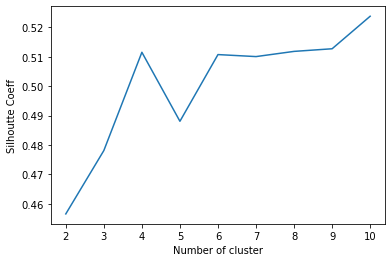

In [280]:
#calculate  with Silhouette score
from sklearn.metrics import silhouette_score

sil_coeffs = {}
labels_sc = {}
for k in range(2, 11):
    sil_coeffs.setdefault(k)
    kmeans_sc = cluster.KMeans(n_clusters=k, random_state=1).fit(X_to_cluster)
    labels_sc[k] = kmeans_sc.labels_
    sil_coeff = silhouette_score(X_to_cluster, labels_sc[k], metric='euclidean')
    sil_coeffs[k]=sil_coeff
plt.plot(sil_coeffs.keys(), sil_coeffs.values())
plt.xlabel("Number of cluster")
plt.ylabel("Silhoutte Coeff")
plt.show()

Looks like reducing the number of features to try to cluster we get a k of 4 satisfying both ways of evaluating the clusters approach. SSE approach may indicate a k of 5 but we can also say that from 4 the returns are diminishing.

The Silhouette Coefficient approach may indicate a cluster of 10 but I will be using 4 because it may be easier to explain in human terms and from 4 to 10 the slope is not as aggressive as up to 4.

### We will choose a k = 4

In [281]:
k = 4
#cluster the whole data not only the selected features
clustered_data_sklearn = cluster.KMeans(n_clusters=k, n_init=10, max_iter=1000).fit(data)

In [282]:
data_and_centers = np.r_[data,clustered_data_sklearn.cluster_centers_]

In [283]:
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
print(XYcoordinates)

[[ 0.54800404  0.79432365]
 [-0.7033789   0.12861237]
 [-0.12888196  1.21118452]
 ...
 [ 0.67886195 -0.28373338]
 [-0.14152367 -0.46175183]
 [-0.78908036  0.2998714 ]]


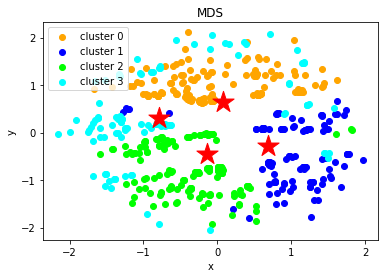

In [284]:
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=clustered_data_sklearn.labels_, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS')

In [285]:
df['cluster'] = pd.Series(clustered_data_sklearn.labels_, index=X.index)

In [286]:
df.head()

,Dependents,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Gender_nan,Married_Yes,Married_nan,Self_Employed_Yes,Self_Employed_nan,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncome,cluster
0,0.000000,1.084523,1.058140,0.75,1,1,0,0,0,0,0,0,0,1,1,0.841086,0
1,0.333333,0.925883,1.047319,0.75,1,1,0,1,0,0,0,0,0,0,0,0.871711,3
2,0.000000,0.683858,0.635920,0.75,1,1,0,1,0,1,0,0,0,1,1,0.385189,0
3,0.000000,0.608992,1.002824,0.75,1,1,0,1,0,0,0,1,0,1,1,0.717012,0
4,0.000000,1.101869,1.115650,0.75,1,1,0,0,0,0,0,0,0,1,1,0.860305,0


In [287]:
df.tail()

,Dependents,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Gender_nan,Married_Yes,Married_nan,Self_Employed_Yes,Self_Employed_nan,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncome,cluster
609,0.000000,0.666409,0.676143,0.750,1,0,0,0,0,0,0,0,0,0,1,0.364708,1
610,1.000000,0.858916,0.395858,0.375,1,1,0,1,0,0,0,0,0,0,1,0.587496,2
611,0.333333,1.313719,1.566110,0.750,1,1,0,1,0,0,0,0,0,1,1,1.116075,0
612,0.666667,1.267616,1.325676,0.750,1,1,0,1,0,0,0,0,0,1,1,1.042256,0
613,0.000000,0.925883,1.074155,0.750,0,0,0,0,0,1,0,0,1,0,0,0.663523,1


In [288]:
df.groupby('cluster').mean()

,Dependents,ApplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Male,Gender_nan,Married_Yes,Married_nan,Self_Employed_Yes,Self_Employed_nan,Education_Not Graduate,Property_Area_Semiurban,Property_Area_Urban,Loan_Status_Y,TotalIncome
cluster,,,,,,,,,,,,,,,,
0,0.255814,0.908651,1.044120,0.692297,0.994186,0.837209,0.017442,0.656977,0.005814,0.110465,0.069767,0.162791,0.000000,1.000000,0.773256,0.854186
1,0.092732,0.914228,1.022330,0.736090,0.932331,0.578947,0.015038,0.000000,0.015038,0.135338,0.067669,0.248120,0.586466,0.000000,0.721805,0.795507
2,0.323625,0.926256,1.130333,0.715898,0.990291,0.878641,0.019417,1.000000,0.000000,0.155340,0.043689,0.194175,0.655340,0.000000,0.932039,0.916496
3,0.284790,0.913556,1.091198,0.714078,0.252427,0.844660,0.038835,0.766990,0.000000,0.126214,0.019417,0.320388,0.194175,0.291262,0.009709,0.856005


In [290]:
order_centroids = clustered_data_sklearn.cluster_centers_.argsort()[:, ::-1]
# for i in range(k):
#     print("Cluster %d:" % i, end="")
#     for ind in order_centroids[i, :10]:
#         print(" %s" % terms[ind], end="")
#     print()
print(order_centroids)

[[13  4  5 14  3  7  2  1 15  0 11  9 10  6  8 12]
 [ 4  3 14 12  5  2  1 11 15  9  0 10  8  6 13  7]
 [ 7  4 14  5  3 12  2  0 15  1 11  9 10  6  8 13]
 [ 5  7  3  2 11 13  0  1 15  4 12  9  6 10 14  8]]


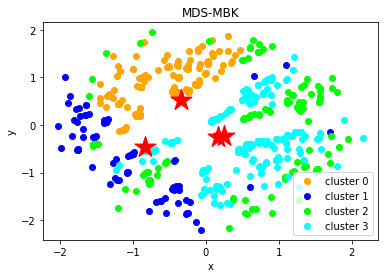

In [297]:
batch_size = 6
k=4

mbk = cluster.MiniBatchKMeans(init='k-means++', n_clusters=k, random_state=0, batch_size=batch_size, n_init=10)
mbk.fit_predict(X)
mbk_means_labels = mbk.labels_
mbk_means_cluster_centers = mbk.cluster_centers_
mbk_means_labels_unique = np.unique(mbk_means_labels)

data_and_centers = np.r_[data,mbk_means_cluster_centers]
XYcoordinates = manifold.MDS(n_components=2).fit_transform(data_and_centers)
clustering_scatterplot(points=XYcoordinates[:-k,:], 
                       labels=mbk_means_labels, 
                       centers=XYcoordinates[-k:,:], 
                       title='MDS-MBK')

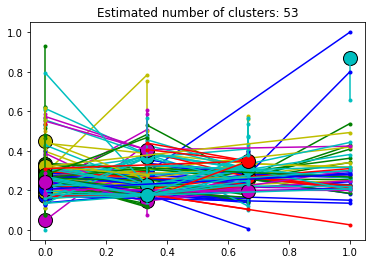

In [272]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle

af = AffinityPropagation(random_state=0, max_iter=250).fit(data)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
n_clusters_ = len(cluster_centers_indices)
preds = af.predict(data)

colours = cycle('bgrcmy')
for ks, col in zip(range(n_clusters_), colours):
    class_members = labels == ks
    cluster_center = data[cluster_centers_indices[ks]]
    plt.plot(data[class_members, 0], data[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in data[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# Conclusion

I have tried a few algorithms for determining the best clusters for the loans data.

A small number of clusters makes it more possible for humans to understand it but that may not always be what the clustering algorithms predict.

AffinityPropagation algorithm finishes very quickly but it comes up with 53 clusters

Using KMeans I've identified a k = 4 as a more suitable number of clusters.

Plotting them using a clustering prediction using KMeans and Mini Batch KMeans produces quite similar results.